### this is the notebook where im making the model, testing out input shapes, plotting stuff. 
## the training python file does the training, but ill have the code here too


In [1]:
import torch
import torchvision
import os
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Download MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.35MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 748kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 20.6MB/s]

Training samples: 60000
Test samples: 10000


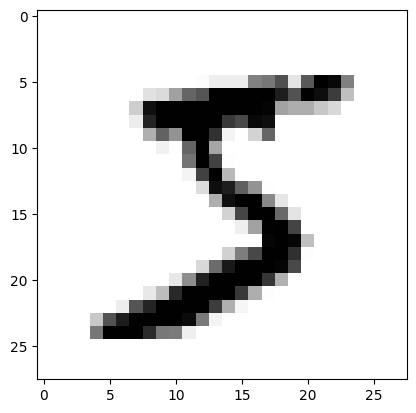

In [14]:
plt.imshow(train_dataset[0][0][0],cmap="binary")
plt.show()

In [ ]:
def space_to_depth(x, size=2):
    """
    Downsacle method that use the depth dimension to
    downscale the spatial dimensions
    Args:
        x (torch.Tensor): a tensor to downscale
        size (float): the scaling factor

    Returns:
        (torch.Tensor): new spatial downscale tensor
    """
    
    b,c,h,w = x.shape()
    
    out_h = h
    out_w = w
    out_c = c * (size*size)
    
    x = x.reshape((-1,c,out_h,size,out_w,size))
    x = x.permute((0,1,3,5,2,4))
    x = x.reshape((-1,out_c,out_h,out_w))
    
    return x


class SpaceToDepth(nn.Module):
    
    def __init__(self,size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.size = size
        
    def forward(self,x):
        return space_to_depth(x,self.size)
    
class Residual(nn.Module):
    """
    Apply residual connection using an input function
    Args:
    func (function): a function to apply over the input
    """
    def __init__(self,func, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.func = func
        
    def forward(self,x,*args,**kwargs):
        return x.self.func(x,*args,**kwargs)
    
def upsample(in_channels,out_channels=None):
    out_channels = in_channels if out_channels is None else out_channels
    seq = nn.Sequential(
        nn.Upsample(scale_factor=2,mode="nearest"),
        nn.conv2d(in_channels,out_channels,3,padding=1)
    )
    return seq

def downsample(in_channels,out_channels=None):
    out_channels = in_channels if out_channels is None else out_channels
    seq = nn.Sequential(
        SpaceToDepth(2),
        nn.Conv2d(4*in_channels, out_channels,1)
    )
    return seq
    